In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
df = pd.read_csv('LargeMovieReviewDataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# EDA + DP

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
TARGET = 'sentiment'
SEED = 40

In [ ]:
df[TARGET].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

The dataset is completelly balanced.

Lets take a look how a review looks like.

In [ ]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

We have special characters, and HTML tags which we need to clean.

## Data cleaning

Text normalization

In [ ]:
tokenizer=ToktokTokenizer()
# nltk.download('stopwords')
stopword_list=nltk.corpus.stopwords.words('english')
print(stopword_list[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Removing HTML tags and noise text

In [ ]:
def strip_html(text):
  soup = BeautifulSoup(text, 'html.parser')
  return soup.get_text()

def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  return text

In [ ]:
df['review'] = df['review'].apply(denoise_text)

In [ ]:
def remove_special_ch(text):
  pattern = r'[^a-zA-Z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

In [ ]:
df['review'] = df['review'].apply(remove_special_ch)

Stemming vs lemmatization

In [ ]:
test_review = df['review'][1]
test_review = test_review.split()
test_review

['A',
 'wonderful',
 'little',
 'production',
 'The',
 'filming',
 'technique',
 'is',
 'very',
 'unassuming',
 'very',
 'oldtimeBBC',
 'fashion',
 'and',
 'gives',
 'a',
 'comforting',
 'and',
 'sometimes',
 'discomforting',
 'sense',
 'of',
 'realism',
 'to',
 'the',
 'entire',
 'piece',
 'The',
 'actors',
 'are',
 'extremely',
 'well',
 'chosen',
 'Michael',
 'Sheen',
 'not',
 'only',
 'has',
 'got',
 'all',
 'the',
 'polari',
 'but',
 'he',
 'has',
 'all',
 'the',
 'voices',
 'down',
 'pat',
 'too',
 'You',
 'can',
 'truly',
 'see',
 'the',
 'seamless',
 'editing',
 'guided',
 'by',
 'the',
 'references',
 'to',
 'Williams',
 'diary',
 'entries',
 'not',
 'only',
 'is',
 'it',
 'well',
 'worth',
 'the',
 'watching',
 'but',
 'it',
 'is',
 'a',
 'terrificly',
 'written',
 'and',
 'performed',
 'piece',
 'A',
 'masterful',
 'production',
 'about',
 'one',
 'of',
 'the',
 'great',
 'masters',
 'of',
 'comedy',
 'and',
 'his',
 'life',
 'The',
 'realism',
 'really',
 'comes',
 'home',


Stemming

In [ ]:
ps = PorterStemmer()
review_s = [ps.stem(word) for word in test_review]

Lemmatizing

In [ ]:
lem = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
review_l = [lem.lemmatize(word) for word in test_review]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print(len(review_s), len(review_l))

156 156


In [ ]:
print(f'{"Original":<20}{"Stemming":<20} {"Lemmitazion":<}')
print('-' * 53, '\n')
for i in range(len(review_s)):
  print(f'{test_review[i]:<20} {review_s[i]:<20} {review_l[i]}')

Original            Stemming             Lemmitazion
----------------------------------------------------- 

A                    a                    A
wonderful            wonder               wonderful
little               littl                little
production           product              production
The                  the                  The
filming              film                 filming
technique            techniqu             technique
is                   is                   is
very                 veri                 very
unassuming           unassum              unassuming
very                 veri                 very
oldtimeBBC           oldtimebbc           oldtimeBBC
fashion              fashion              fashion
and                  and                  and
gives                give                 give
a                    a                    a
comforting           comfort              comforting
and                  and                  and
sometimes     

As we can see, stemming is sometimes cut the word's end off, for example 'little' to 'littl', 'terribly' -> 'terribl'.

However, lemmitazion is keep sometimes unimportant tags, like 'concern**ing**'

Lets move on with stemming, I think it keeps the original word without unimportant tags of the words + lower case it immediately.

In [ ]:
def simple_stemmer(text):
  ps = PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

df['review'] = df['review'].apply(simple_stemmer)

In [ ]:
df['review'][0]

'one of the other review ha mention that after watch just 1 oz episod youll be hook they are right as thi is exactli what happen with meth first thing that struck me about oz wa it brutal and unflinch scene of violenc which set in right from the word go trust me thi is not a show for the faint heart or timid thi show pull no punch with regard to drug sex or violenc it is hardcor in the classic use of the wordit is call oz as that is the nicknam given to the oswald maximum secur state penitentari it focus mainli on emerald citi an experiment section of the prison where all the cell have glass front and face inward so privaci is not high on the agenda em citi is home to manyaryan muslim gangsta latino christian italian irish and moreso scuffl death stare dodgi deal and shadi agreement are never far awayi would say the main appeal of the show is due to the fact that it goe where other show wouldnt dare forget pretti pictur paint for mainstream audienc forget charm forget romanceoz doesnt 

Remove stopwords

In [ ]:
stop = set(stopwords.words('english'))
print(stop)

{"don't", 'our', 'didn', 'on', 't', 'few', 'have', 'wasn', 'again', "wasn't", 'only', "isn't", 'wouldn', "didn't", 'are', 'm', 'o', 'because', 'will', 'further', "aren't", 'ours', 'why', 'd', 'such', 'himself', 'what', 'that', "you'd", 'from', 'he', 'against', 'isn', 'so', 'doesn', 'until', 'with', 'very', "mightn't", 'too', 'should', "weren't", 'there', 'other', 'can', 'don', 'if', 'his', "you're", 'been', 'when', 'their', 's', 'each', 'itself', 'does', 're', "should've", "wouldn't", 'while', 'an', 'out', 'own', "hasn't", 'ma', "shan't", 'couldn', 'yours', 'both', 'is', "shouldn't", 'same', 'some', 'be', 'not', 'ourselves', "that'll", 'them', 'below', 'aren', 'hasn', 'had', 'my', 'hadn', 'yourself', "haven't", 'me', 'in', 'at', 'theirs', 'who', 'now', "doesn't", "needn't", 'above', 'any', 'about', 'all', 'you', 'ain', 'its', 'than', 'being', 'mightn', 'between', 'won', "you'll", 'she', 'do', 'then', 'were', 'of', 'those', 'your', 'through', 'll', 'these', 'just', 'down', 've', 'after'

In [ ]:
def remove_stopwords(text):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token not in stopword_list]

  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

In [ ]:
df['review'] = df['review'].apply(remove_stopwords)

In [ ]:
df['review'][0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

As we can see the review got shorter.

## Statistical analysis

I put this part here, because we cleaned the text, and can represent some interesting things about the reviews.

Text(0, 0.5, 'Word')

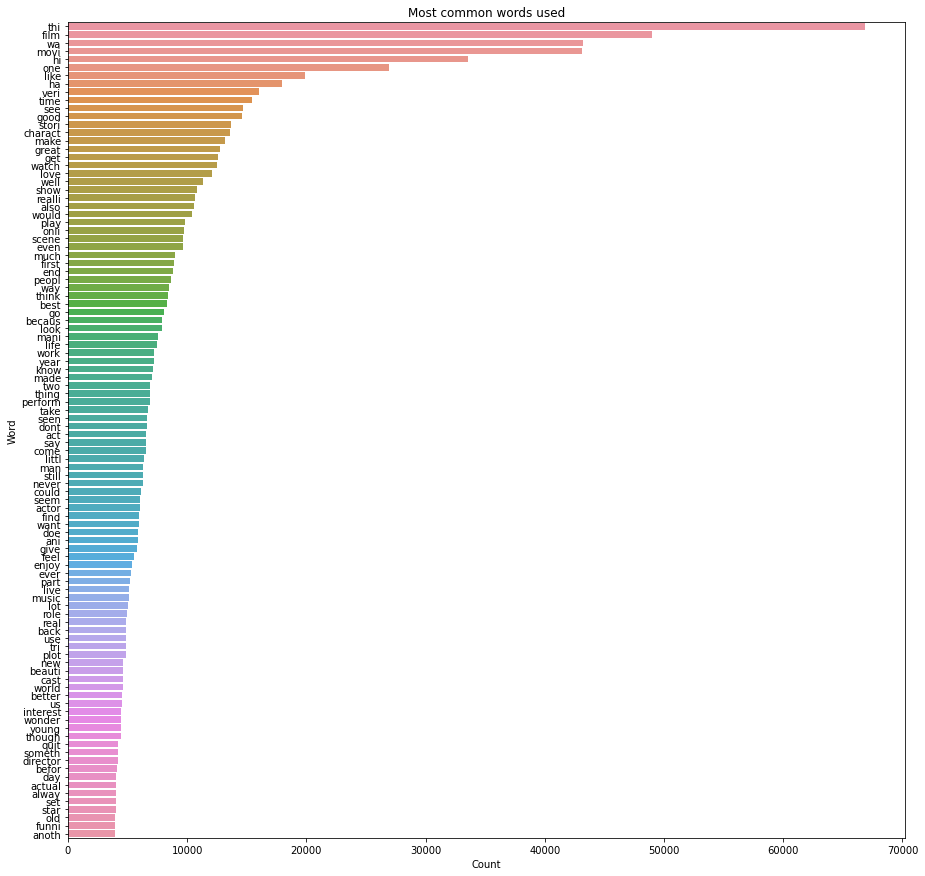

In [ ]:
from collections import Counter

def create_corpus(word):
  corpus = []

  for x in df[df[TARGET] == word]['review'].str.split():
    for i in x:
      corpus.append(i)
  return corpus


stops=set(stopwords.words('english'))

corpus = create_corpus('positive')
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []

for word, count in most[:100]:
  if (word not in stops):
    x.append(word)
    y.append(count)
  
plt.figure(figsize = (15, 15))
sns.barplot(x = y, y = x)
plt.title('Most common words used')
plt.xlabel('Count')
plt.ylabel('Word')

Words used in positive vs negative reviews

(-0.5, 1599.5, 799.5, -0.5)

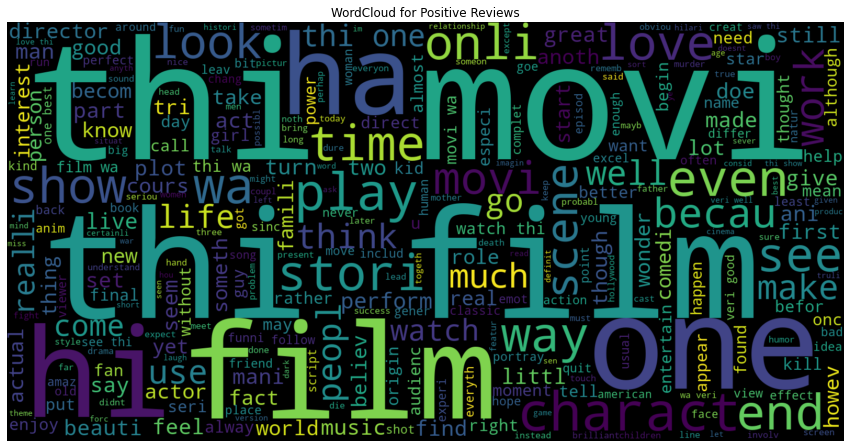

In [ ]:
plt.figure(figsize = (15, 15))
wc = WordCloud(max_words = 300 , width = 1600 , height = 800).generate(' '.join(df[df.sentiment == 'positive'].review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('WordCloud for Positive Reviews')
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

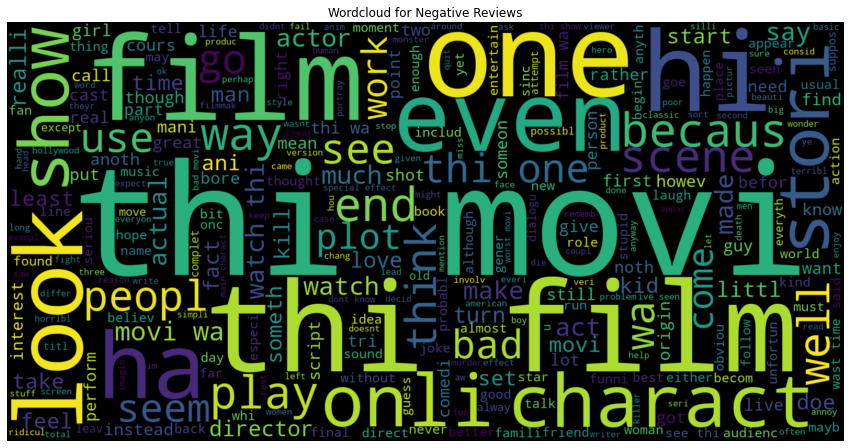

In [ ]:
plt.figure(figsize = (15, 15))
wc = WordCloud(max_words = 300 , width = 1600 , height = 800).generate(' '.join(df[df.sentiment == 'negative'].review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for Negative Reviews')
plt.axis('off')

Number of words in positive vs negative reviews

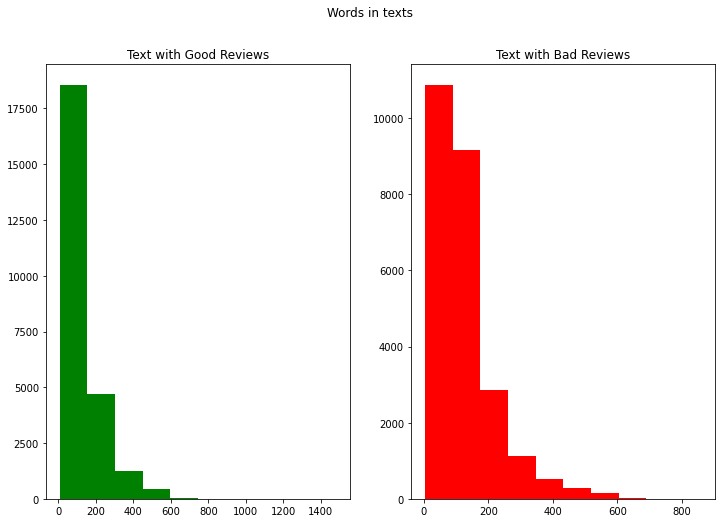

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))

text_len=df[df['sentiment']=='positive']['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')

text_len=df[df['sentiment']=='negative']['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')

fig.suptitle('Words in texts')
plt.show()

As we can clearly see here, the positive reviews are more likely to be longer than the negative ones.

# Split

In [ ]:
# test/train = 20% = 40000/50000
train_X = df['review'][:40000]
train_y = df[TARGET][:40000]

test_X = df['review'][40000:]
test_y = df[TARGET][40000:]

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(40000,) (40000,)
(10000,) (10000,)


# Models

### Bag of Words

In [ ]:
cv = CountVectorizer(min_df = 0, max_df = 1, binary = False, ngram_range = (1, 3))

cv_train_X = cv.fit_transform(train_X)
cv_test_X = cv.transform(test_X)

print('BOW_cw_train:', cv_train_X.shape)
print('BOW_cw_test', cv_test_X.shape)

BOW_cw_train: (40000, 6208633)
BOW_cw_test (10000, 6208633)


Bag of Words made a huge amount of features

### TFIDF

Term Frequency - Inverse Document Frequency model (TFIDF)

In [ ]:
tv = TfidfVectorizer(min_df = 0, max_df = 1, use_idf = True, ngram_range = (1, 3))

tv_train_X = tv.fit_transform(train_X)
tv_test_X = tv.transform(test_X)

print('tfidf_train:', tv_train_X.shape)
print('tfidf_test:', tv_test_X.shape)

tfidf_train: (40000, 6208633)
tfidf_test: (10000, 6208633)


Labeling the sentiment text

In [ ]:
lb = LabelBinarizer()

sentiment_df = lb.fit_transform(df['sentiment'])
print(sentiment_df.shape)

(50000, 1)


Split sentiment data

In [ ]:
train_y = sentiment_df[:40000]
test_y = sentiment_df[40000:]

Modeling the dataset

## Logistic Regression

In [ ]:
lr = LogisticRegression(penalty = 'l2', max_iter = 500, C = 1, random_state = SEED)

lr_bow = lr.fit(cv_train_X, train_y)
print(lr_bow)

lr_tfidf = lr.fit(tv_train_X, train_y)
print(lr_tfidf)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=40)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=40)


In [ ]:
lr_bow_predict = lr.predict(cv_test_X)
print(lr_bow_predict)

lr_tfidf_predict = lr.predict(tv_test_X)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [ ]:
print(confusion_matrix(test_y, lr_bow_predict))

[[3744 1249]
 [1237 3770]]


In [ ]:
print(classification_report(test_y, lr_bow_predict))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      4993
           1       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [ ]:
print(confusion_matrix(test_y, lr_tfidf_predict))

[[3836 1157]
 [1345 3662]]


In [ ]:
print(classification_report(test_y, lr_tfidf_predict))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      4993
           1       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



They got almost the same score.

## SVM

In [ ]:
svm = SGDClassifier(loss = 'hinge', max_iter = 500, random_state = SEED)
svm_bow = svm.fit(cv_train_X, train_y)

svm_tfidf = svm.fit(tv_train_X, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM perform much faster than logistic regression.

In [ ]:
svm_bow_predict = svm.predict(cv_test_X)
svm_tfidf_predict = svm.predict(tv_test_X)

In [ ]:
print(confusion_matrix(test_y, svm_bow_predict))

[[4904   89]
 [3908 1099]]


In [ ]:
print(classification_report(test_y, svm_bow_predict))

              precision    recall  f1-score   support

           0       0.56      0.98      0.71      4993
           1       0.93      0.22      0.35      5007

    accuracy                           0.60     10000
   macro avg       0.74      0.60      0.53     10000
weighted avg       0.74      0.60      0.53     10000



In [ ]:
print(confusion_matrix(test_y, svm_tfidf_predict))

[[4992    1]
 [4954   53]]


In [ ]:
print(classification_report(test_y, svm_tfidf_predict))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4993
           1       0.98      0.01      0.02      5007

    accuracy                           0.50     10000
   macro avg       0.74      0.51      0.34     10000
weighted avg       0.74      0.50      0.34     10000



SGD CLassifier model is performing poor.

## SVC

In [ ]:
# svc = SVC(kernel = 'linear')

# svc_bow = svc.fit(cv_train_X, train_y)
# print(lr_bow)

# svc_tfidf = svc.fit(tv_train_X, train_y)
# print(lr_tfidf)

SVC run forever, so I can't test it unfortunatelly.

## Naive Bayes

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()

# gnb_bow = gnb.fit(cv_train_X.toarray(), train_y)
# print(lr_bow)

# gnb_tfidf = gnb.fit(tv_train_X.toarray(), train_y)
# print(lr_tfidf)

I can't try out this too, colab just crash...

In [ ]:
mnb=MultinomialNB()

mnb_bow = mnb.fit(cv_train_X,train_y)
print(mnb_bow)

mnb_tfidf = mnb.fit(tv_train_X, train_y)
print(mnb_tfidf)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [ ]:
mnb_bow_predict = mnb.predict(cv_test_X)
mnb_tfidf_predict = mnb.predict(tv_test_X)

In [ ]:
print(confusion_matrix(test_y, mnb_bow_predict))

[[3773 1220]
 [1270 3737]]


In [ ]:
print(classification_report(test_y, svm_bow_predict))

              precision    recall  f1-score   support

           0       0.56      0.98      0.71      4993
           1       0.93      0.22      0.35      5007

    accuracy                           0.60     10000
   macro avg       0.74      0.60      0.53     10000
weighted avg       0.74      0.60      0.53     10000



In [ ]:
corpus = df['review'].tolist()

In [ ]:
cv = CountVectorizer(max_features = 1500)

In [ ]:
X = cv.fit_transform(corpus).toarray()
y = df[TARGET].values

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
           X, y, test_size = 0.25, random_state = 0)

In [ ]:
from sklearn.naive_bayes import GaussianNB
 
classifier = GaussianNB();
classifier.fit(X_train, y_train)
 
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm

array([[5364,  927],
       [1975, 4234]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.73      0.85      0.79      6291
    positive       0.82      0.68      0.74      6209

    accuracy                           0.77     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.78      0.77      0.77     12500



These scores are good enough.

Overall: Logistic regression and Naive Bayes gave the best results. I think SVM could perform even better, but due to time constraints I can't run a 6-8+ hour training session.


The cleaning part was very necessary and important. I did everything I could think of that could possibly make the learning better.


I personally am not very interested in NLP, unlike Image Processing. I've been working on a complex biological image detection/classification project for the past year and I'm more interested in this topic. Maybe that's why I haven't found a match with this topic.